# LIBRARIES

In [1]:
# LIBRARIES ----
import scipy.stats as st
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

pd.set_option('float_format', lambda x: '%.2f' % x)

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# MODELS ----
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# METRICS ----
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [6]:
# DATA ----
data_path = r'C:\Users\USER\OneDrive\Desktop\dsFolder\MLPrac\Classification\vsScript\churn.csv'

data = pd.read_csv(data_path)
data.drop(
    columns=['Unnamed: 0'],
    inplace=True
); data.head()

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave
0,zero,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,one,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,one,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,zero,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,one,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


In [8]:
# DATA UNDERSTANDING ----
print(data.info())
print(data.describe().T)
print(f'\nNumber of duplicates: {data.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   college                      20000 non-null  object
 1   income                       20000 non-null  int64 
 2   overage                      20000 non-null  int64 
 3   leftover                     20000 non-null  int64 
 4   house                        20000 non-null  int64 
 5   handset_price                20000 non-null  int64 
 6   over_15mins_calls_per_month  20000 non-null  int64 
 7   average_call_duration        20000 non-null  int64 
 8   reported_satisfaction        20000 non-null  object
 9   reported_usage_level         20000 non-null  object
 10  considering_change_of_plan   20000 non-null  object
 11  leave                        20000 non-null  object
dtypes: int64(7), object(5)
memory usage: 1.8+ MB
None
                               count  

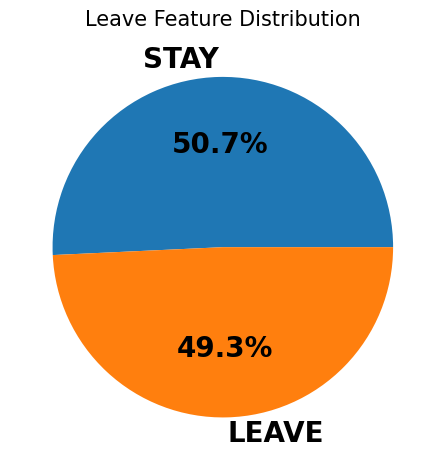

In [9]:
# -PART 01 -EXPLORATORY DATA ANALYSIS-
plt.figure()
plt.pie(data['leave'].value_counts(), labels=data['leave'].value_counts().keys(),
        autopct='%1.1f%%', textprops={'fontsize': 20, 'fontweight': 'black'})
plt.title('Leave Feature Distribution', size=15)
plt.tight_layout()
plt.show()

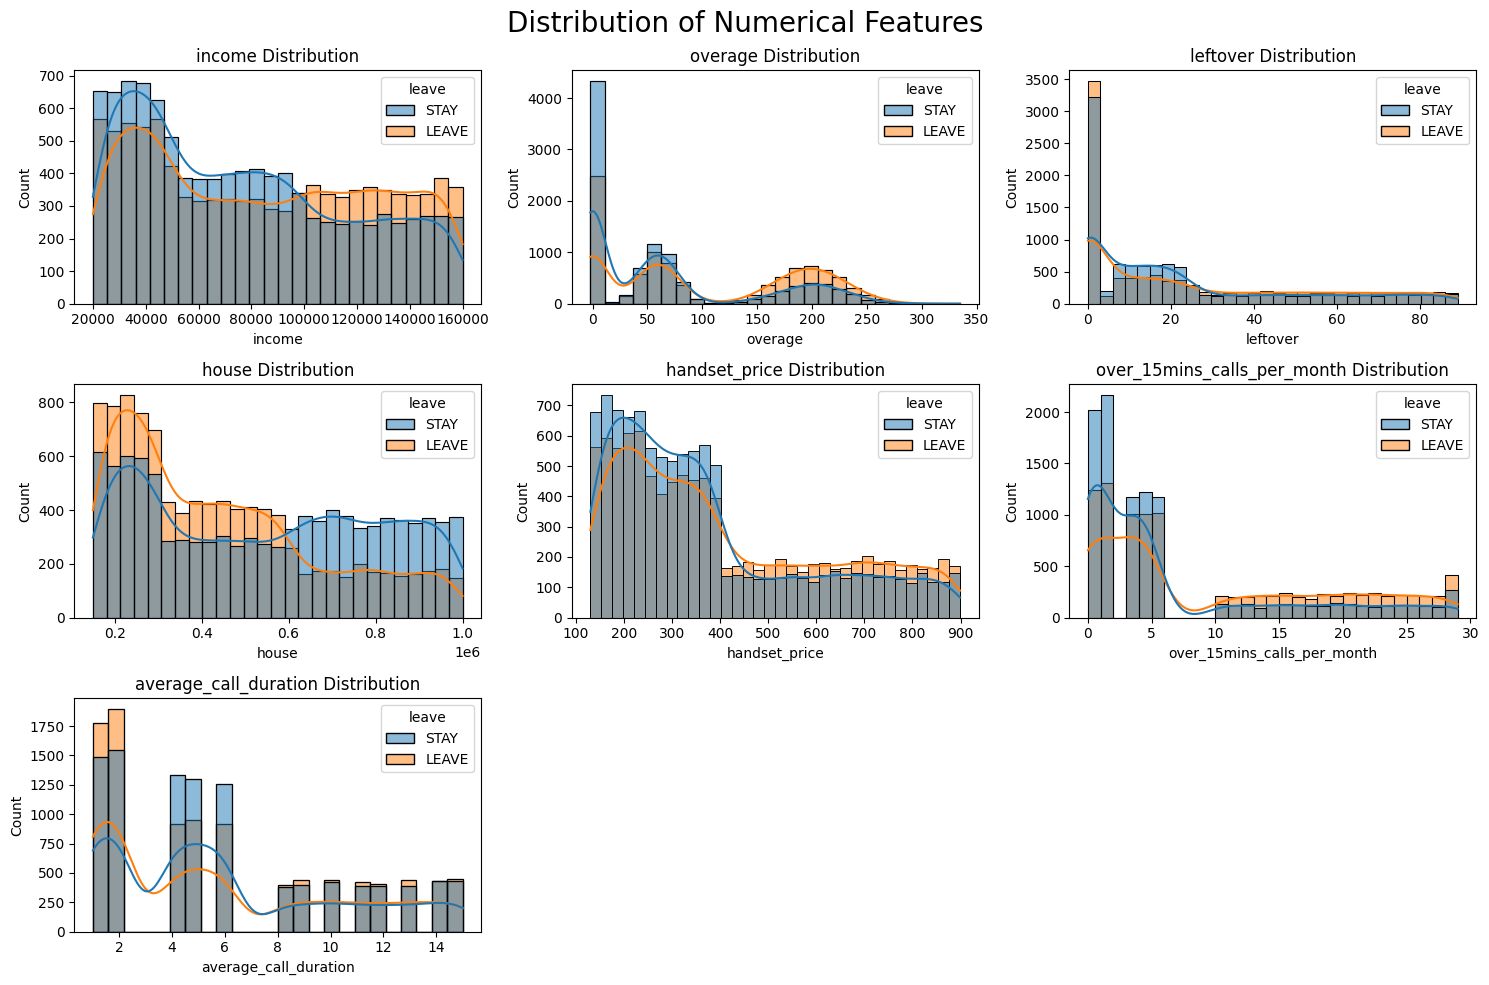

In [10]:
# VISUALIZING NUMERICAL FEATURES
data.select_dtypes(include='int').columns

int_cols = ['income', 'overage', 'leftover', 'house', 'handset_price',
            'over_15mins_calls_per_month', 'average_call_duration']

plt.figure(figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features', size=20)
for idx, column in enumerate(int_cols):
    plt.subplot(3, 3, idx+1)
    sns.histplot(x=column, hue='leave', data=data, kde=True)
    plt.title(f'{column} Distribution')

plt.tight_layout()
plt.show()

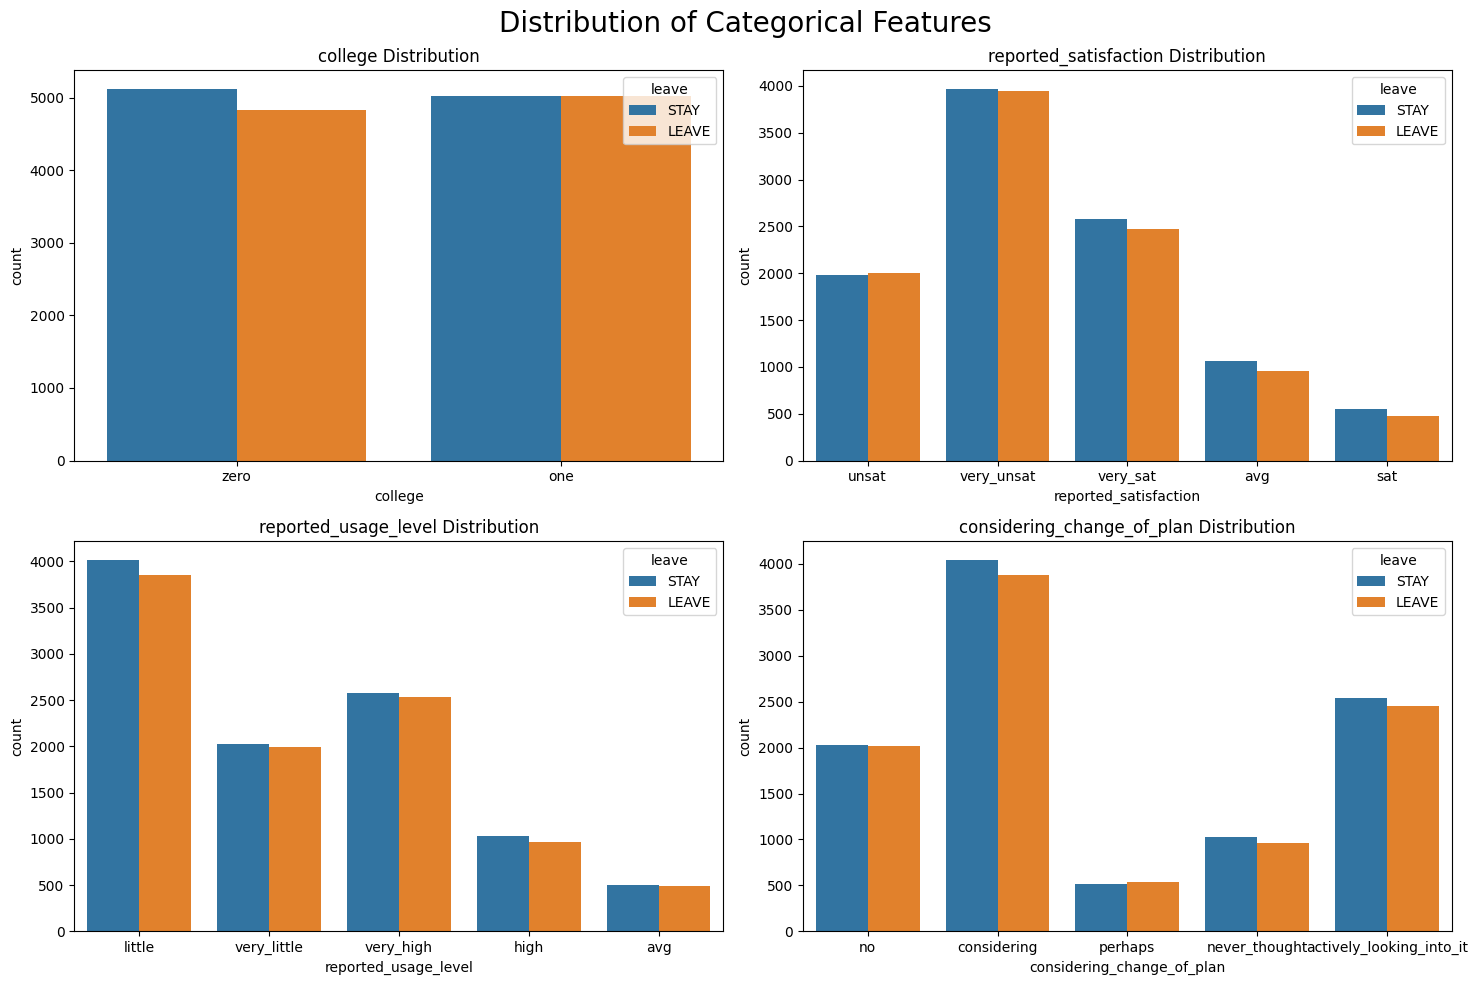

In [11]:
# VISUALIZING CATEGORICAL FEATURES
data.select_dtypes(include='object').columns

cat_cols = ['college', 'reported_satisfaction',
            'reported_usage_level', 'considering_change_of_plan']

plt.figure(figsize=(15, 10))
plt.suptitle('Distribution of Categorical Features', size=20)
for idx, column in enumerate(cat_cols):
    plt.subplot(2, 2, idx+1)
    sns.countplot(x=column, hue='leave', data=data)
    plt.title(f'{column} Distribution')

plt.tight_layout()
plt.show()

In [12]:
# PART 02 -FEATURE ENGINEERING-
# reported_satisfaction
data.select_dtypes(include=['object'])


def satisfaction(df):
    satisfaction = []
    for i in df['reported_satisfaction']:
        if i == 'very_unsat' or i == 'unsat':
            satisfaction.append('a_unsatisfied')
        else:
            satisfaction.append('satisfied')

    df['satisfaction'] = satisfaction


satisfaction(data)

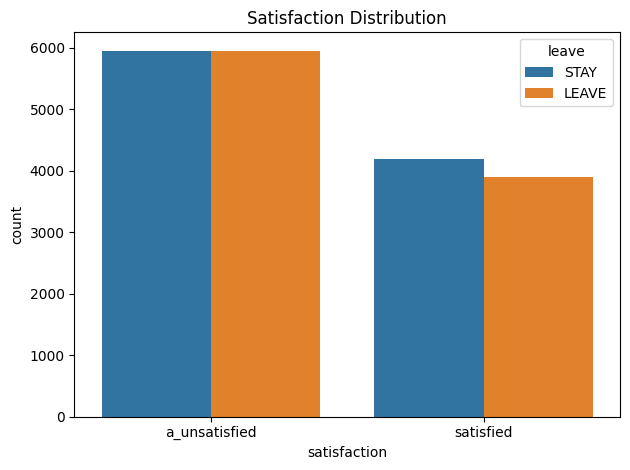

In [13]:
# VISUALIZING ENGINEERED SATISFACTION----
order = sorted(data['satisfaction'].value_counts().keys().to_list())

plt.figure()
sns.countplot(x='satisfaction', hue='leave', data=data, order=order)
plt.title('Satisfaction Distribution')

plt.tight_layout()
plt.show()

In [14]:
# reported_usage_level----
def usage_level(df):
    usage_level = []
    for i in df['reported_usage_level']:
        if i == 'very_high' or i == 'high':
            usage_level.append('high')
        else:
            usage_level.append('a_little')

    df['usage_level'] = usage_level


usage_level(data)

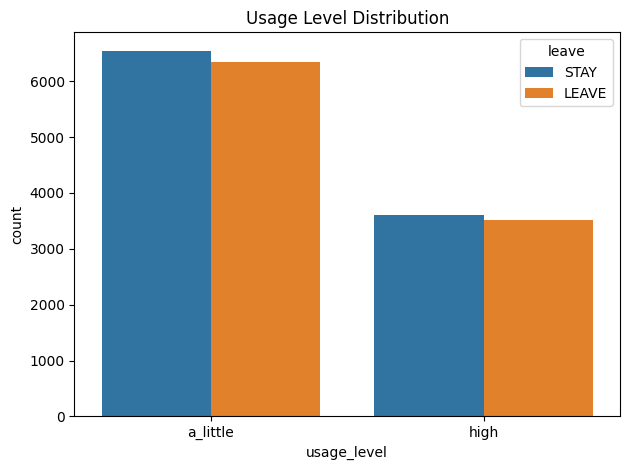

In [15]:
# VISUALIZING ENGINEERED USAGE LEVEL----
order = sorted(data['usage_level'].value_counts().keys().to_list())

plt.figure()
sns.countplot(x='usage_level', hue='leave', data=data, order=order)
plt.title('Usage Level Distribution')

plt.tight_layout()
plt.show()

In [16]:
# considering_change_of_plan----
def change_of_plan(df):
    change_of_plan = []
    for i in df['considering_change_of_plan']:
        if i == 'no' or i == 'never_thought':
            change_of_plan.append('a_no')
        else:
            change_of_plan.append('considering')

    df['change_of_plan'] = change_of_plan


change_of_plan(data)

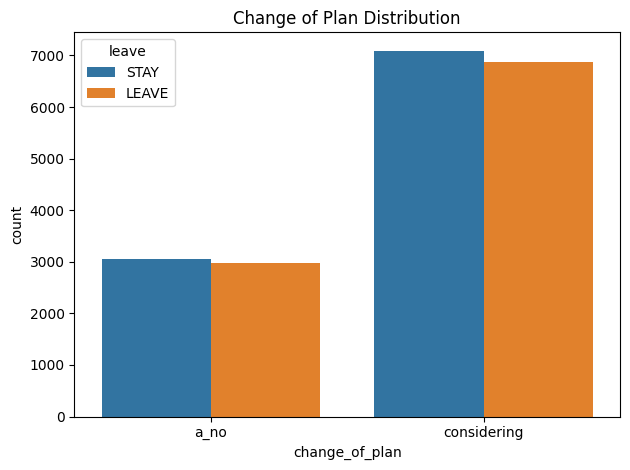

In [17]:
# VISUALIZING ENGINEERED CHANGE OF PLAN----
order = sorted(data['change_of_plan'].value_counts().keys().to_list())

plt.figure()
sns.countplot(x='change_of_plan', hue='leave',
              data=data, order=order)
plt.title('Change of Plan Distribution')

plt.tight_layout()
plt.show()

In [18]:
# DROPPING UNNECESSARY COLUMNS
data.head()
data.drop(columns=['reported_satisfaction', 'reported_usage_level',
                   'considering_change_of_plan'], inplace=True)


# PART 03 -ONE-HOT-ENCONDING-
data.columns

data['leave'] = pd.Categorical(data['leave'],
                               categories=['STAY', 'LEAVE'],
                               ordered=True)

data['college'] = [1 if yi == 'one' else 0 for yi in data['college']]

predictors = [
    'college', 'income', 'overage', 'leftover', 'house', 'handset_price',
    'over_15mins_calls_per_month', 'average_call_duration',
    'satisfaction', 'usage_level', 'change_of_plan'
]
outcome = 'leave'

# -NOTE: AVOID DUMMY VARIABLE TRAP-
X = pd.get_dummies(data[predictors],
                   drop_first=True,
                   dtype='int')
y = [1 if yi == 'STAY' else 0 for yi in data[outcome]]  # 1 -STAY; 0 -LEAVE

X

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,satisfaction_satisfied,usage_level_high,change_of_plan_considering
0,0,31953,0,6,313378,161,0,4,0,0,0
1,1,36147,0,13,800586,244,0,6,0,0,1
2,1,27273,230,0,305049,201,16,15,0,0,1
3,0,120070,38,33,788235,780,3,2,0,1,1
4,1,29215,208,85,224784,241,21,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
19995,0,153252,0,23,368403,597,1,6,1,0,1
19996,1,107126,71,82,237397,609,5,2,1,0,0
19997,0,78529,0,66,172589,275,0,2,0,1,1
19998,0,78674,47,41,572406,288,4,2,0,0,1


In [19]:
# PART 04 -DATA PREPARATION-
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42)

# SCALED DATA FOR SENSITIVE MODEL
# SENSITIVE MODEL:
# -KNeighborsClassifier
# -LogisticRegression
# -SVC
# -AdaBoostClassifier
# -GradientBoostingClassifier

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train1, X_temp1, y_train1, y_temp1 = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

X_val1, X_test1, y_val1, y_test1 = train_test_split(
    X_temp1, y_temp1, test_size=1/3, random_state=42)

In [20]:
# PART 05 -MODEL TRAINING-
# TRAINING A NON-SCALED DATA

training_score = []
val_score = []


def model_prediction(model):
    model.fit(X_train, y_train)
    X_train_pred = model.predict(X_train)
    X_val_pred = model.predict(X_val)
    train = accuracy_score(y_train, X_train_pred) * 100
    val = accuracy_score(y_val, X_val_pred) * 100
    training_score.append(train)
    val_score.append(val)
    # METRICS -----
    print(f'{model} Training Accuracy Score:', train)
    print(f'{model} Validation Set Accuracy Score:', val)
    print('\n------------------------------------')
    print(f'{model} Precision Score:', precision_score(y_val, X_val_pred))
    print(f'{model} Recall Score:', recall_score(y_val, X_val_pred))
    print(f'{model} F1 Score:', f1_score(y_val, X_val_pred))
    print('\n------------------------------------')
    # ROC AND AUC -----
    print(f'{model} ROC Curve and AUC:')
    X_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, X_proba)
    roc_df = pd.DataFrame({
        'recall': tpr,
        'specificity': fpr
    })

    plt.figure()
    roc_df.plot(x='specificity', y='recall',
                label='ROC curve(AUC = %0.2f)' % auc(fpr, tpr))
    plt.title(f'{model} ROC & AUC')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.plot([0, 1], [0, 1], ls='--')
    plt.xlabel('specificity')
    plt.ylabel('recall')

    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# GaussianNB
# XGBClassifier
# RandomForestClassifier
# DecisionTreeClassifier
# LightGBMClassifier
# CatBoostClassifier

GaussianNB() Training Accuracy Score: 63.76428571428572
GaussianNB() Validation Set Accuracy Score: 63.6

------------------------------------
GaussianNB() Precision Score: 0.6277340332458443
GaussianNB() Recall Score: 0.7034313725490197
GaussianNB() F1 Score: 0.6634304207119742

------------------------------------
GaussianNB() ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

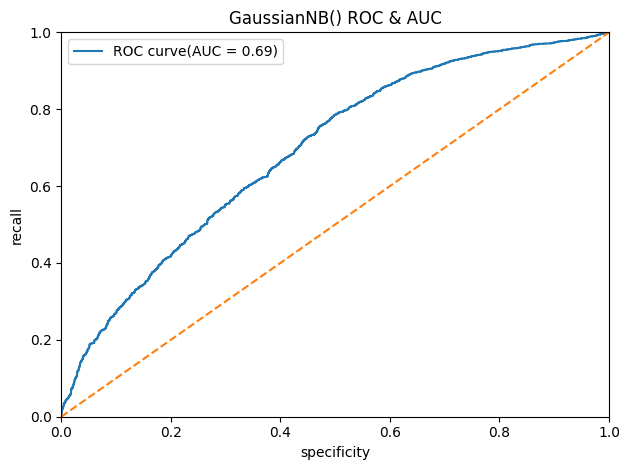

In [21]:
model_prediction(GaussianNB())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) Training Accuracy Score: 85.67857142857143
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enab

<Figure size 640x480 with 0 Axes>

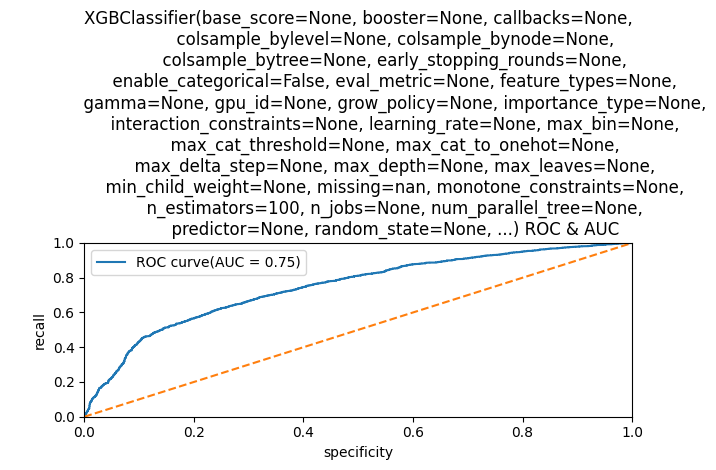

In [22]:
model_prediction(XGBClassifier())

RandomForestClassifier() Training Accuracy Score: 99.99285714285713
RandomForestClassifier() Validation Set Accuracy Score: 69.675

------------------------------------
RandomForestClassifier() Precision Score: 0.7157016171100679
RandomForestClassifier() Recall Score: 0.6725490196078432
RandomForestClassifier() F1 Score: 0.693454637351529

------------------------------------
RandomForestClassifier() ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

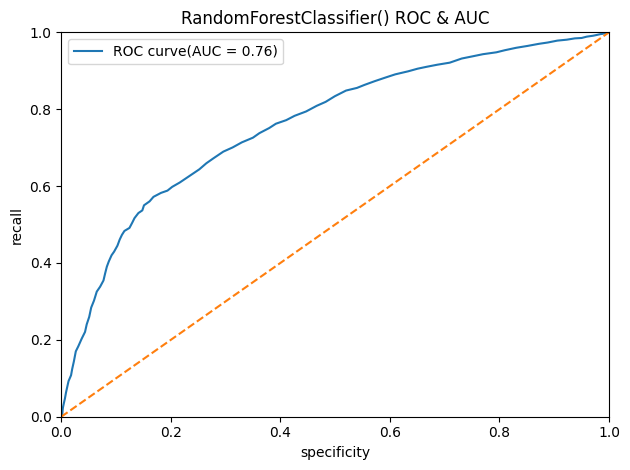

In [23]:
model_prediction(RandomForestClassifier())

DecisionTreeClassifier() Training Accuracy Score: 100.0
DecisionTreeClassifier() Validation Set Accuracy Score: 61.525

------------------------------------
DecisionTreeClassifier() Precision Score: 0.6211901306240929
DecisionTreeClassifier() Recall Score: 0.6294117647058823
DecisionTreeClassifier() F1 Score: 0.6252739225712199

------------------------------------
DecisionTreeClassifier() ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

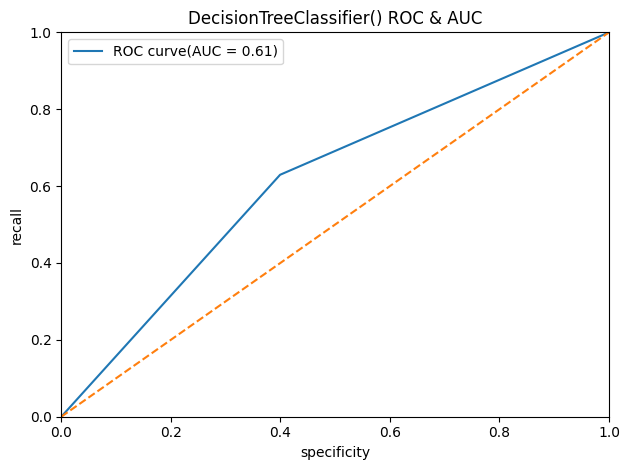

In [24]:
model_prediction(DecisionTreeClassifier())

[LightGBM] [Info] Number of positive: 7102, number of negative: 6898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507286 -> initscore=0.029145
[LightGBM] [Info] Start training from score 0.029145
LGBMClassifier() Training Accuracy Score: 78.59285714285714
LGBMClassifier() Validation Set Accuracy Score: 69.625

------------------------------------
LGBMClassifier() Precision Score: 0.7190653212958046
LGBMClassifier() Recall Score: 0.6637254901960784
LGBMClassifier() F1 Score: 0.6902880448636247

------------------------------------
LGBMClassifier() ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

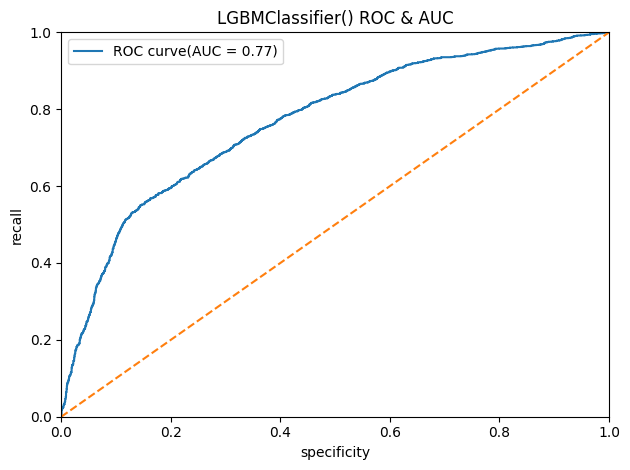

In [26]:
model_prediction(LGBMClassifier())

<catboost.core.CatBoostClassifier object at 0x0000020A983156D0> Training Accuracy Score: 78.89285714285714
<catboost.core.CatBoostClassifier object at 0x0000020A983156D0> Validation Set Accuracy Score: 69.35

------------------------------------
<catboost.core.CatBoostClassifier object at 0x0000020A983156D0> Precision Score: 0.7100103199174407
<catboost.core.CatBoostClassifier object at 0x0000020A983156D0> Recall Score: 0.6745098039215687
<catboost.core.CatBoostClassifier object at 0x0000020A983156D0> F1 Score: 0.6918049270990447

------------------------------------
<catboost.core.CatBoostClassifier object at 0x0000020A983156D0> ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

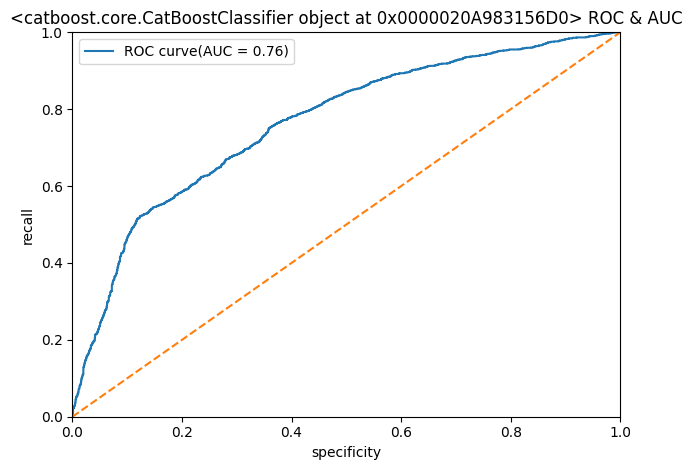

In [27]:
model_prediction(CatBoostClassifier(verbose=False))

In [28]:
# TRAINING A SCALED DATA

def scaled_prediction(model):
    model.fit(X_train1, y_train1)
    X_train_pred1 = model.predict(X_train1)
    X_val_pred1 = model.predict(X_val1)
    train = accuracy_score(y_train1, X_train_pred1) * 100
    val = accuracy_score(y_val1, X_val_pred1) * 100
    training_score.append(train)
    val_score.append(val)

    print(f'{model} Training Accuracy Score:', train)
    print(f'{model} Validation Set Accuracy Score:', val)
    print('\n------------------------------------')
    print(f'{model} Precision Score:', precision_score(y_val1, X_val_pred1))
    print(f'{model} Recall Score:', recall_score(y_val1, X_val_pred1))
    print(f'{model} F1 Score:', f1_score(y_val1, X_val_pred1))
    print('\n------------------------------------')

    print(f'{model} ROC Curve and AUC:')
    X_proba1 = model.predict_proba(X_val1)[:, 1]
    fpr1, tpr1, thresholds1 = roc_curve(y_val1, X_proba1)
    roc_df1 = pd.DataFrame({
        'recall': tpr1,
        'specificity': fpr1
    })
    # auc = auc(fpr, tpr)

    plt.figure()
    roc_df1.plot(x='specificity', y='recall',
                 label='ROC curve(AUC = %0.2f)' % auc(fpr1, tpr1))
    plt.title(f'{model} ROC & AUC')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.plot([0, 1], [0, 1], ls='--')
    plt.xlabel('specificity')
    plt.ylabel('recall')

    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# KNeighborsClassifier
# LogisticRegression
# SVC
# AdaBoostClassifier
# GradientBoostingClassifier

KNeighborsClassifier() Training Accuracy Score: 76.5
KNeighborsClassifier() Validation Set Accuracy Score: 64.825

------------------------------------
KNeighborsClassifier() Precision Score: 0.6525301204819277
KNeighborsClassifier() Recall Score: 0.6637254901960784
KNeighborsClassifier() F1 Score: 0.6580801944106927

------------------------------------
KNeighborsClassifier() ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

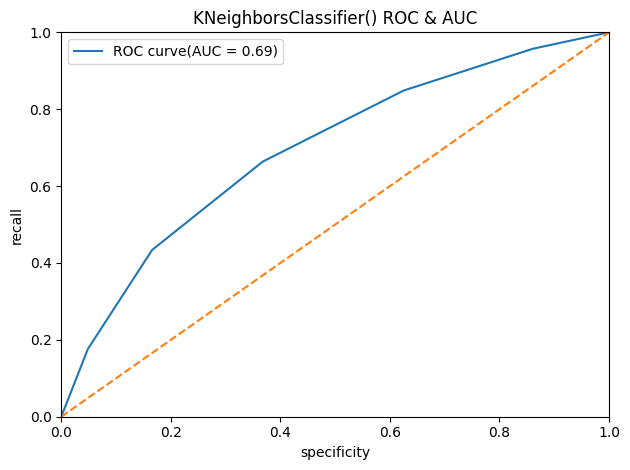

In [29]:
scaled_prediction(KNeighborsClassifier())

LogisticRegression() Training Accuracy Score: 64.19285714285714
LogisticRegression() Validation Set Accuracy Score: 63.65

------------------------------------
LogisticRegression() Precision Score: 0.6399235912129895
LogisticRegression() Recall Score: 0.6568627450980392
LogisticRegression() F1 Score: 0.6482825350749878

------------------------------------
LogisticRegression() ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

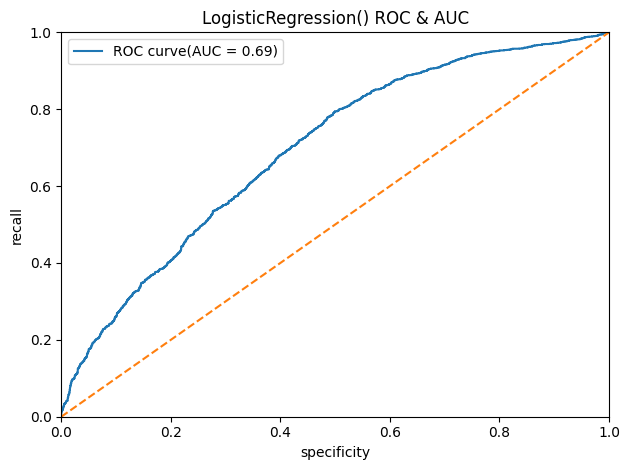

In [30]:
scaled_prediction(LogisticRegression())

SVC(probability=True) Training Accuracy Score: 70.31428571428572
SVC(probability=True) Validation Set Accuracy Score: 67.4

------------------------------------
SVC(probability=True) Precision Score: 0.6697416974169742
SVC(probability=True) Recall Score: 0.711764705882353
SVC(probability=True) F1 Score: 0.6901140684410646

------------------------------------
SVC(probability=True) ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

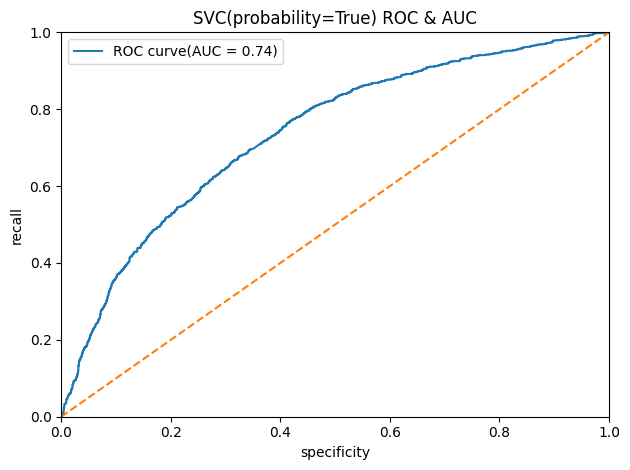

In [31]:
scaled_prediction(SVC(probability=True))

AdaBoostClassifier() Training Accuracy Score: 67.2642857142857
AdaBoostClassifier() Validation Set Accuracy Score: 65.9

------------------------------------
AdaBoostClassifier() Precision Score: 0.6648780487804878
AdaBoostClassifier() Recall Score: 0.6681372549019607
AdaBoostClassifier() F1 Score: 0.6665036674816626

------------------------------------
AdaBoostClassifier() ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

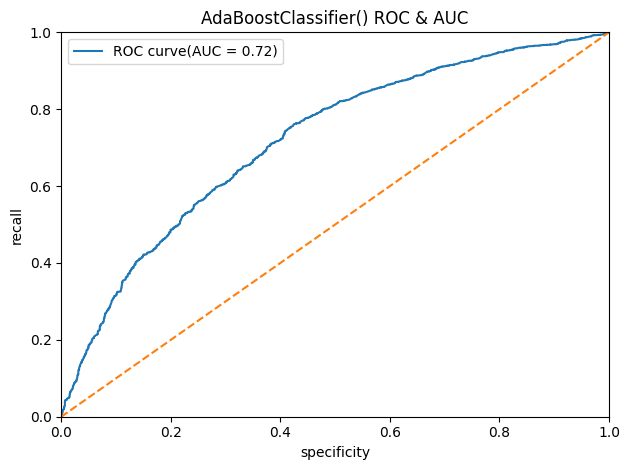

In [32]:
scaled_prediction(AdaBoostClassifier())

GradientBoostingClassifier() Training Accuracy Score: 72.18571428571428
GradientBoostingClassifier() Validation Set Accuracy Score: 68.5

------------------------------------
GradientBoostingClassifier() Precision Score: 0.7044025157232704
GradientBoostingClassifier() Recall Score: 0.6588235294117647
GradientBoostingClassifier() F1 Score: 0.6808510638297872

------------------------------------
GradientBoostingClassifier() ROC Curve and AUC:


<Figure size 640x480 with 0 Axes>

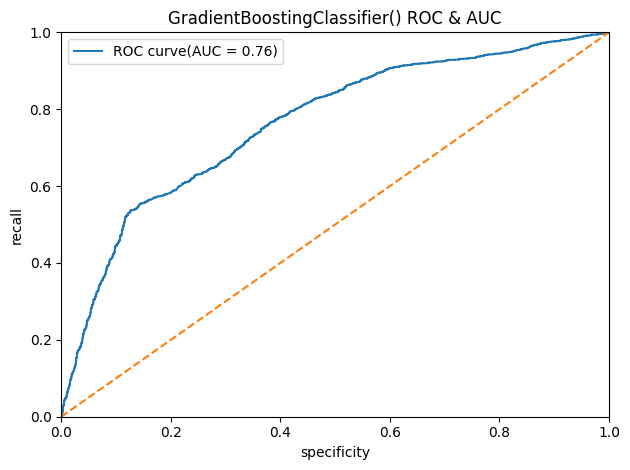

In [33]:
scaled_prediction(GradientBoostingClassifier())

In [34]:
# PART 06 -  ALL MODEL PERFORMANCE COMPARISON
models = [
    'GaussianNB', 'XGBClassifier', 'RandomForestClassifier',
    'DecisionTreeClassifier', 'LightGBMClassifier', 'CatBoostClassifier',
    'KNeighborsClassifier', 'LogisticRegression', 'SVC',
    'AdaBoostClassifier', 'GradientBoostingClassifier'
]

# CREATING DATAFRAME FOR PERFORMANCE
perf = pd.DataFrame({
    'Algorithms': models,
    'Training Score': training_score,
    'Validation Score': val_score
})
perf

,Algorithms,Training Score,Validation Score
0,GaussianNB,63.76,63.60
1,XGBClassifier,85.68,68.25
2,RandomForestClassifier,99.99,69.67
3,DecisionTreeClassifier,100.00,61.52
4,LightGBMClassifier,78.59,69.62
5,CatBoostClassifier,78.89,69.35
6,KNeighborsClassifier,76.50,64.83
7,LogisticRegression,64.19,63.65
8,SVC,70.31,67.40
9,AdaBoostClassifier,67.26,65.90
